Krešimir Kumerički,<br>
<center><b><font size="5">Neural net fit to CLAS 2015 DVCS cross-section data and the resulting D-term and its uncertainty</font></b></center><br>
This is the jupyter/python code accompanying comment on the paper Burkert, V. D., Elouadrhiri, L. and Girod, F. X., <i>The pressure distribution inside the proton</i>, Nature, <b>557</b> 396-399 (2018).

# Software initialization

Jupyter initialization:

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Standard python packages:

In [2]:
import shelve, logging, sys, copy
logging.basicConfig(level=logging.ERROR)
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# We want nice LaTeX fonts on plots
plt.rc('text', usetex=True)
params = {'text.latex.preamble' : [r'\usepackage{amssymb}', r'\usepackage{amsmath}']}
plt.rcParams.update(params)

GeParD GPD code (not public yet)

In [4]:
GEPARD_DIR = '/home/kkumer/gepard'
sys.path.append(GEPARD_DIR+'/pype')
import Model, Approach, Fitter, Data, utils, plots
from results import *
from abbrevs import *
from constants import Mp2, toTeX

We also load model databases:

In [5]:
db = shelve.open(GEPARD_DIR+'/pype/theories.db')   # KM fits etc.
dbndr = shelve.open(GEPARD_DIR+'/pype/nndr.db')    # NNet fits

In [6]:
th15 = db['KM15']
th12 = db['KMM12']

# Formulas: D-term, subtraction constant, pressure

## Definitions

First the definitions. We are concerned with three closely related quantities:

1. GPD D-term  $D(\alpha, t)$

This is the extra term in the double-distribution GPD represenatation, with support in ERBL region only:

$$ H^{a}(x,\eta, t) = \cdots + \theta(-\eta < x < \eta)\: D^{a}\left(\frac{x}{\eta}, t\right)
\qquad a = q,g$$

2. Gravitational form factor $d_1(t)$

$$ \langle p' | T^{a}_{\mu\nu}(0) | p \rangle = u'\Big(\cdots + d^{a}_1(t)
\frac{\Delta_{\mu}\Delta_{\nu} - g_{\mu\nu}\Delta^2}{5 m}\Big) u
$$

which is often redefined as $D(t)\equiv \frac{4}{5} d_{1}(t)$, and often also called D-term. 

3. Compton form factor subtraction constant $\Delta(t)$

$$
\Re e\,\mathcal{H}(\xi,t) = \frac{1}{\pi} {\rm P.V.}
\int_{0}^{1} dx \left(\frac{1}{\xi-x} - \frac{1}{\xi+x}\right)\Im m\,\mathcal{H} (\xi,t)
+ \Delta(t)
$$

## Relations

These quantites are related. First by Gegenbauer expansion of GPD D-term

$$
D^{a}(\alpha, t) = (1-\alpha^2) \sum_{n,{\rm odd}} d_{n}^a C_{n}^{(3/2)}(\alpha)
$$

Also, with the help of LO QCD factorization formula expressing CFFs as integrals over GPDs,

$$
\Delta(t) = 2 \sum_q Q_{q}^2 \int_{-1}^{1} d\alpha \frac{D_{q}(\alpha, t)}{1-\alpha}
= 4\sum_q Q_{q}^2 \big(d_{1}^q(t) + d_{3}^q(t) + \cdots\big)
$$

Additionally, coefficient of highest power in odd Mellin moment of GPD

$$
\int_{-1}^1 x^n H^{a}(x,\eta,t) = \cdots + \eta^{n+1} h^{a(n)}_{n+1}
$$

is related to GPD D-term

$$
 h^{(n)}_{n+1} = \int_{-1}^{1} d\alpha\, \alpha^n D(\alpha, t)
$$

and, in particular,

$$
h_{2}^{(1)}  = \frac{4}{5} d_1
$$

## Pressure distribution

Pressure distribution resulting from D-term is (see e.g. Eqs. (29a) and (35b) in arXiv:[1805.06596](https://www.arXiv.org/abs/1805.06596)):

$$
p(r) = \frac{1}{24 \pi^2 m} \int_{-\infty}^0 dt \, \frac{\sin(r \sqrt{-t})}{r}\, t D(t)
$$

This is in principle valid only for total quark+gluon system.

To obtain $p(r)$ from DVCS, which provides access only to subtraction constant $\Delta(t)$, one thus needs several assumptions.

1. Forget about gluons. From DIS/PDF experience there are about one third of gluons at average $x_{\rm B}$ of CLAS kinematics. At LO, they don't contribute to DVCS much, so one can assume that $\Delta(t)$ is dominantly coming from quarks. To talk about "quark pressure" one also needs to neglect energy-momentum flow from quarks to gluons described by EMT form factor $\tilde{c}(t)$. This assumption can be supported by recent results by Maxim and Son within instanton liquid model where contribution of $\tilde{c}(t)$ is less than 20% of quark D-term. (Lattice will also have results about this soon.)

2. Forget about strange and heavier quarks. O.K. more or less.

3. Neglect higher terms in Gegenbauer expansion ($d_{3}(t)$, $d_{5}(t)$, ...). This to some extent supported by ChiQSM results and should be good assumption for large $Q^2$ (EIC!) because QCD evolution kills all Gegenbauer moments apart from the first one.

Under these assumptions one obtains the relation

$$
\Delta(t) = 4 \left( \frac{4}{9} d_{1}^{u}(t) + \frac{1}{9} d_{1}^{d}(t) \right)
$$

To compare with results of quark models, one needs some assumption on u-d flavour structure. Maxim/Peter propose to rely on large-$N_c$ limit $d_{1}^u = d_{1}^{d} = d_{1}^{Q}/2$ which leads, for $D^{Q}(t)\equiv \frac{4}{5} d^{Q}_{1}(t)$, to
 
$$
D^{Q}(t) = \frac{18}{25} \Delta(t) \:.
$$

Alternatively, on could follow assumptions of KM parametrization $d_{1}^u = 2 d_{1}^{d} = 2 d_{1}^{Q}/3$, which leads to

$$
D^{Q}(t) = \frac{3}{5} \Delta(t)
$$

Two approaches differ less than 20% which is not so important at the level of present phenomenology.

# Neural net fit to CLAS 2015 data

## CLAS datasets

Data that is used by Bukert et al. is CLAS 2015 data on unpolarized DVCS cross-section:

In [7]:
utils.listdata([98,100], data)

[ 98]     CLAS 2640       BSS 1504.02009 CLAS data base E145M1
[100]     CLAS 1152       BSS 1504.02009 CLAS data base E145M1, restricted kinematics


where in `ID=100` dataset we removed some problematic points (such as those with very low $Q^2$). This set is what is used for e.g. `KM15` global fits

Also used is older beam spin asymmetry data:

In [8]:
utils.listdata([7], data)     # analysis by CLAS

[  7]     CLAS  62       BSA  0711.4805 private table


... while the newer polarized DVCS cross-section data 

In [9]:
utils.listdata([97,99], data)

[ 97]     CLAS 2640       BSD 1504.02009 CLAS data base E145M2
[ 99]     CLAS 1152       BSD 1504.02009 CLAS data base E145M2, restricted kinematics


only seems to be used by Burkert et al. for consistency checks (since it is not statistically independent from old BSA data).

For some fits and plots below, also harmonics (Fourier transforms) of the above data are used:

In [10]:
utils.listdata([101,102], data)

[101]     CLAS  48      BSDw 1504.02009 FT analysis with MC error propagation by KK
[102]     CLAS  96      BSSw 1504.02009 FT analysis with MC error propagation by KK


We transform some datasets to pandas frames for easier manipulations

In [11]:
BSA = data[7].df()   # ALU(90 deg) by CLAS 2007
BSS = data[102].df()  # CLAS 2015
BSD = data[101].df()  # CLAS 2015

In [12]:
BSDphi = data[97].df()   # unrestricted CLAS 2015, phi-dep

Bins can be defined as ranges within the following limiting values:

In [13]:
tmlims = [0, 0.13, 0.18, 0.22, 0.3, 0.4, 0.5]
xilims = [0, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21, 0.23, 0.26]

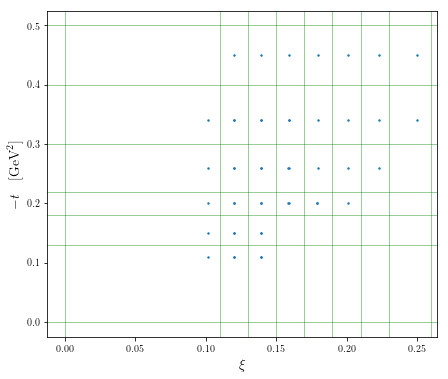

In [14]:
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSD.xi, BSD.tm, s=2)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)
fig.savefig('figs/bins.pdf')

Old 2007 data offers also one low $\xi \sim 0.05$ bin which seems to be used in Nature paper:

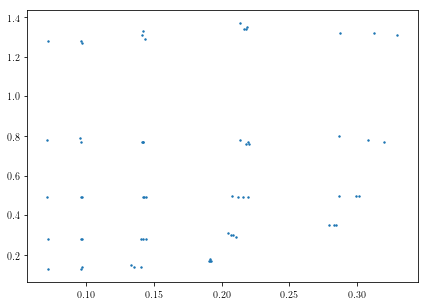

In [15]:
plt.scatter(BSA.xi, BSA.tm, s=2)

Note that for global fits we removed some extreme data from 2015 CLAS dataset. The complete dataset has also some additional low $\xi$ data:

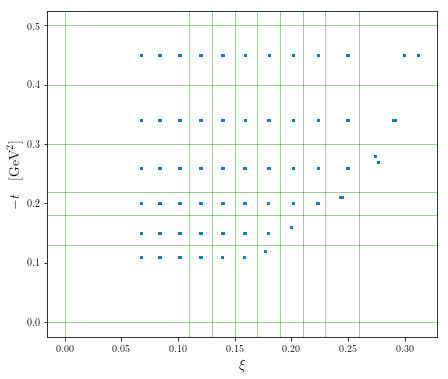

In [16]:
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSDphi.xi, BSDphi.tm, s=2)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)
fig.savefig('figs/bins.pdf')

## Fits

To determine uncertainties, we do the neural net fit to CLAS 2015 BSS and BSD data. We work with multilayer perceptrons provided by publicly available package `pybrain`. Network architecture is:
   * two input neurons (for $x_{\rm B}$ and $t$)
   * seven neurons in hidden layers
   * one neuron in output layer for each required CFF, so 2 for (ImH, ReH)

We performed relevant checks and convinced ourselves that results don't depend on the details of net architecture i.e. number and size of hidden layers.

In [17]:
DONN = False   # We did the fits below once and saved it

In [18]:
if DONN:
    # Model creation
    mNN = Model.ModelNN(output_layer=['ImH', 'ReH'])
    tNN = Approach.BM10tw2(mNN)
    fNN = Fitter.FitterBrain(data[101] + data[102], tNN, nnets=10, nbatch=10)
    fNN.fit()
    tNN.m.parameters['nnet'] = 'ALL'

In [19]:
if DONN:
    tNN.description = '10x10 nnets CLAS BSSw+BSDw, chisq/dof=1'
    tNN.name = 'NN-CLAS-XS'
    tNN.save(db)

And now the same but with ReH-tilde instead of ReH:

In [20]:
if DONN:
    # Model creation
    mNN2 = Model.ModelNN(output_layer=['ImH', 'ReHt'])
    tNN2 = Approach.BM10tw2(mNN2)
    fNN2 = Fitter.FitterBrain(data[101] + data[102], tNN2, nnets=10, nbatch=10)
    fNN2.fit()
    tNN2.m.parameters['nnet'] = 'ALL'

The code above is just for demonstration purpose. Using some batch scripts, we performed more extensive neural net fits, training 10 or 80 neural nets, and with various choices for number of CFFs used. These results are stored in a database of models:

In [21]:
utils.listdb(dbndr)

-------------------+--------------------------------------------------------------
name               |  description
-------------------+--------------------------------------------------------------
NNDR-C15-2         |  10 NNs C15 13.8/36 p=1
NNDR-C15-4t        |  10 NNs C15 18.1/36 p=0.994
NNDR-C15-4         |  10 NNs C15 14.6/36 p=0.999
NNDR-C15-6         |  10 NNs C15 18.5/36 p=0.993
NNDR-C15-8         |  10 NNs C15 18.1/36 p=0.994
NNDR-C15_ALUI-2    |  10 NNs C15+ALUI 18.6/42 p=0.999
NNDR-C15_ALUI-4t   |  10 NNs C15+ALUI 31.8/42 p=0.875
NNDR-C15_ALUI-4    |  10 NNs C15+ALUI 18.8/42 p=0.999
NNDR-C15_ALUI-6    |  10 NNs C15+ALUI 29.6/42 p=0.926
NNDR-C15_ALUI-8    |  10 NNs C15+ALUI 30.2/42 p=0.913
NNDRL-C15-4        |  80 NNs C15 13.4/36 p=1
NNDRL-C15_ALUI-4   |  80 NNs C15+ALUI 21.7/42 p=0.996


Name of the fit/model is constructed in the following way. First `NNDR` means that neural net fits are performed with dispersion relations (DR) constraint active. Then training datasets are named `C15` for CLAS 2015 data and `ALUI` for HERMES $A_{\rm LU, I}$. Finally, number of CFFs in the output layer is given (2-8). Particular CFFs are:

In [22]:
for key in dbndr:
    th = dbndr[key]
    print("{:18s} |  {}".format(th.name, th.m.output_layer))

NNDR-C15-2         |  ['ImH', 'ReH']
NNDR-C15-4t        |  ['ImH', 'ReH', 'ImHt', 'ReHt']
NNDR-C15-4         |  ['ImH', 'ReH', 'ImE', 'ReE']
NNDR-C15-6         |  ['ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt']
NNDR-C15-8         |  ['ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt']
NNDR-C15_ALUI-2    |  ['ImH', 'ReH']
NNDR-C15_ALUI-4t   |  ['ImH', 'ReH', 'ImHt', 'ReHt']
NNDR-C15_ALUI-4    |  ['ImH', 'ReH', 'ImE', 'ReE']
NNDR-C15_ALUI-6    |  ['ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt']
NNDR-C15_ALUI-8    |  ['ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt']
NNDRL-C15-4        |  ['ImH', 'ReH', 'ImE', 'ReE']
NNDRL-C15_ALUI-4   |  ['ImH', 'ReH', 'ImE', 'ReE']


## Analysis of results and determination of D-term

To obtain the uncertainty bands, one averages over all nets of a given model. For example, all nets of CFF-H-only model:

In [23]:
th = dbndr['NNDR-C15-2']

In [24]:
ths = []
for k in range(len(th.m.nets)):
    tha = copy.deepcopy(th)
    #tha.name = '{}-{}'.format(k, tha.name)
    tha.name = None
    tha.m.parameters['nnet'] = k
    ths.append(tha)

/usr/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


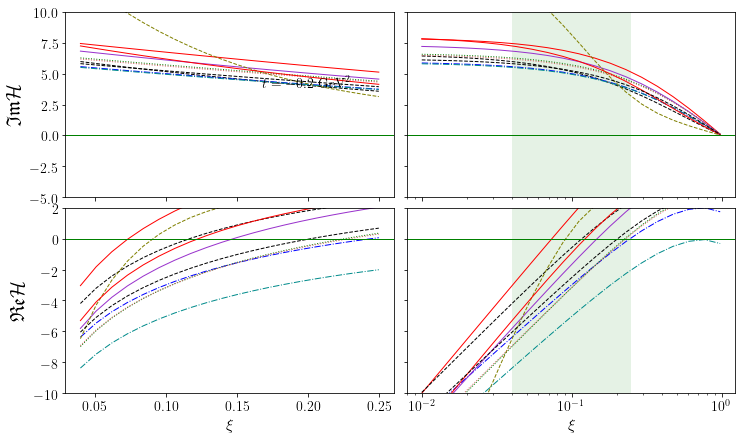

In [25]:
fig = plots.CFF(lines=ths, cffs=['ImH', 'ReH'])

In [26]:
fig.savefig('figs/NN-mesh.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

This is then averaged to become:

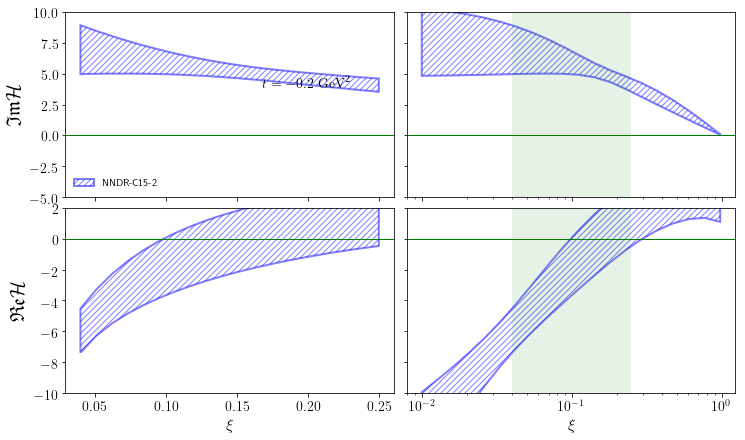

In [27]:
fig = plots.CFF(bands=[th], cffs=['ImH', 'ReH'])

In [28]:
fig.savefig('figs/NNDR.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

To demonstrate that 10 neural nets are enough to reach sensible accuracy, we compare CFF $\mathcal{H}$ as obtained with 10 and with 80 neural nets trained on CLAS 2015 data, labeled as `NNDR-C15-4` and `NNDRL-C15-4`, respectively:

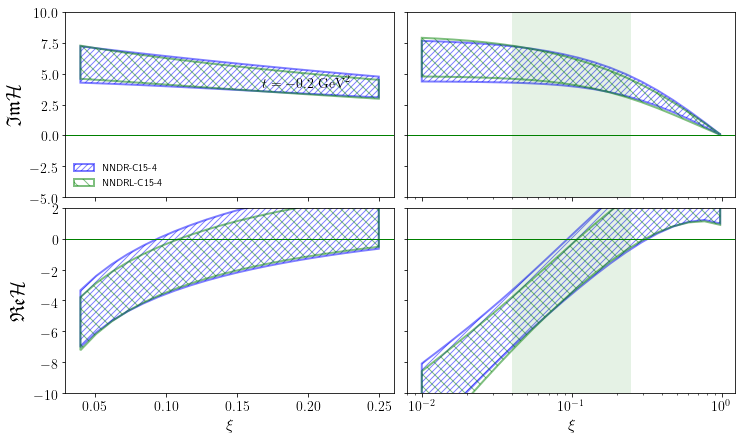

In [29]:
fig = plots.CFF(bands=[dbndr['NNDR-C15-4'], dbndr['NNDRL-C15-4']], cffs=['ImH', 'ReH'])

This is close enough, so the rest of the analysis will be done with 10 NNets per model, for the reasons of speed (it takes a day or so of CPU time to produce 10 NNets).

Fits are actually performed in harmonics space. To see that fit is good, let's see $\chi^2/{\rm d.o.f.}$ in $\phi$-space and in harmonics space:

In [30]:
%%time
th.print_chisq(utils.select(data[99]+data[100], criteria=['err > 0']))

P(chi-square, d.o.f) = P(1725.08, 2028) = 1.0000
CPU times: user 14min 13s, sys: 110 ms, total: 14min 14s
Wall time: 14min 15s


In [31]:
%%time
th.print_chisq(data[101]+data[102])

P(chi-square, d.o.f) = P(51.09, 144) = 1.0000
CPU times: user 1min, sys: 9.99 ms, total: 1min
Wall time: 1min


And, for a good measure, some plots of observables (NN fits w.r.t. actual experimental data) also in $\phi$ and in harmonic space:

CPU times: user 1min, sys: 73.2 ms, total: 1min
Wall time: 1min


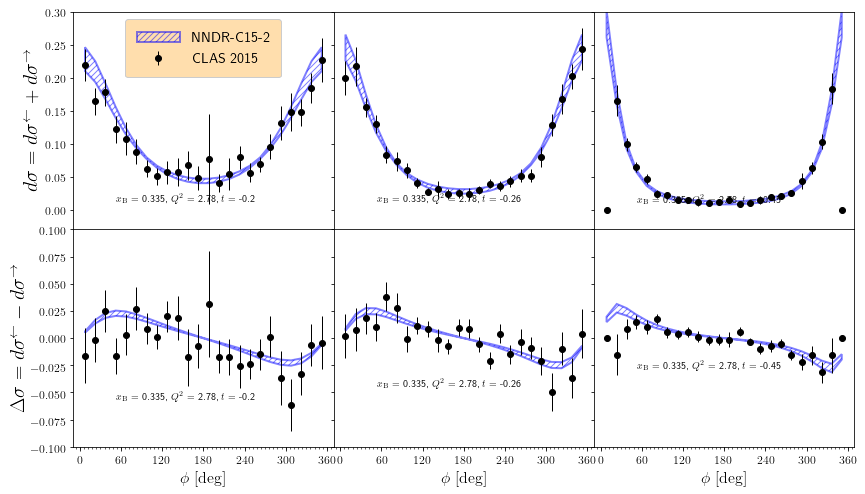

In [32]:
%%time
fig = plots.CLAS15phi(bands=[th])

In [33]:
fig.savefig('figs/NNDR-CLAS15phi.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

CPU times: user 46.6 s, sys: 30 ms, total: 46.6 s
Wall time: 46.7 s


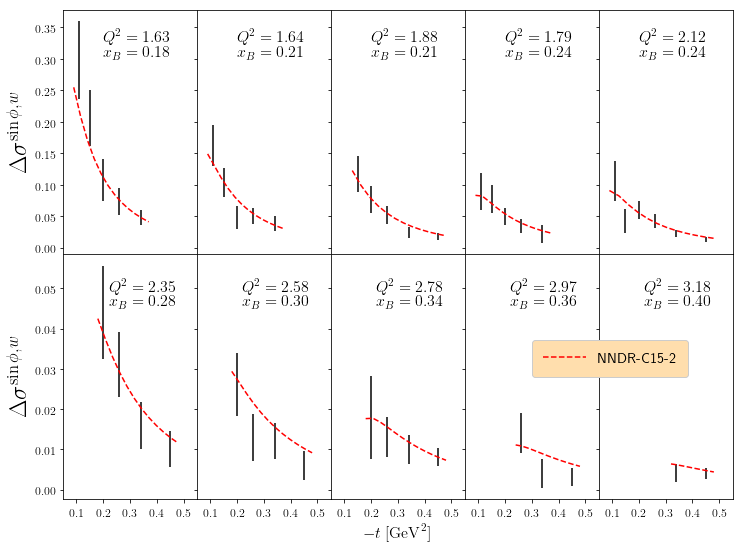

In [34]:
%%time
figw = plots.CLAS15xs(lines=[th])

In [35]:
figw.savefig('figs/NNDR-CLAS15.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

To see the dependence of extracted CFF $\mathcal{H}$ on assumption wheter other CFFs contribute or not, let's compare fits with only-$\mathcal{H}$ model to fit with all LO twist-2 CFFs ($\mathcal{H}$, $\mathcal{E}$, $\tilde{\mathcal{H}}$, $\tilde{\mathcal{E}}$):

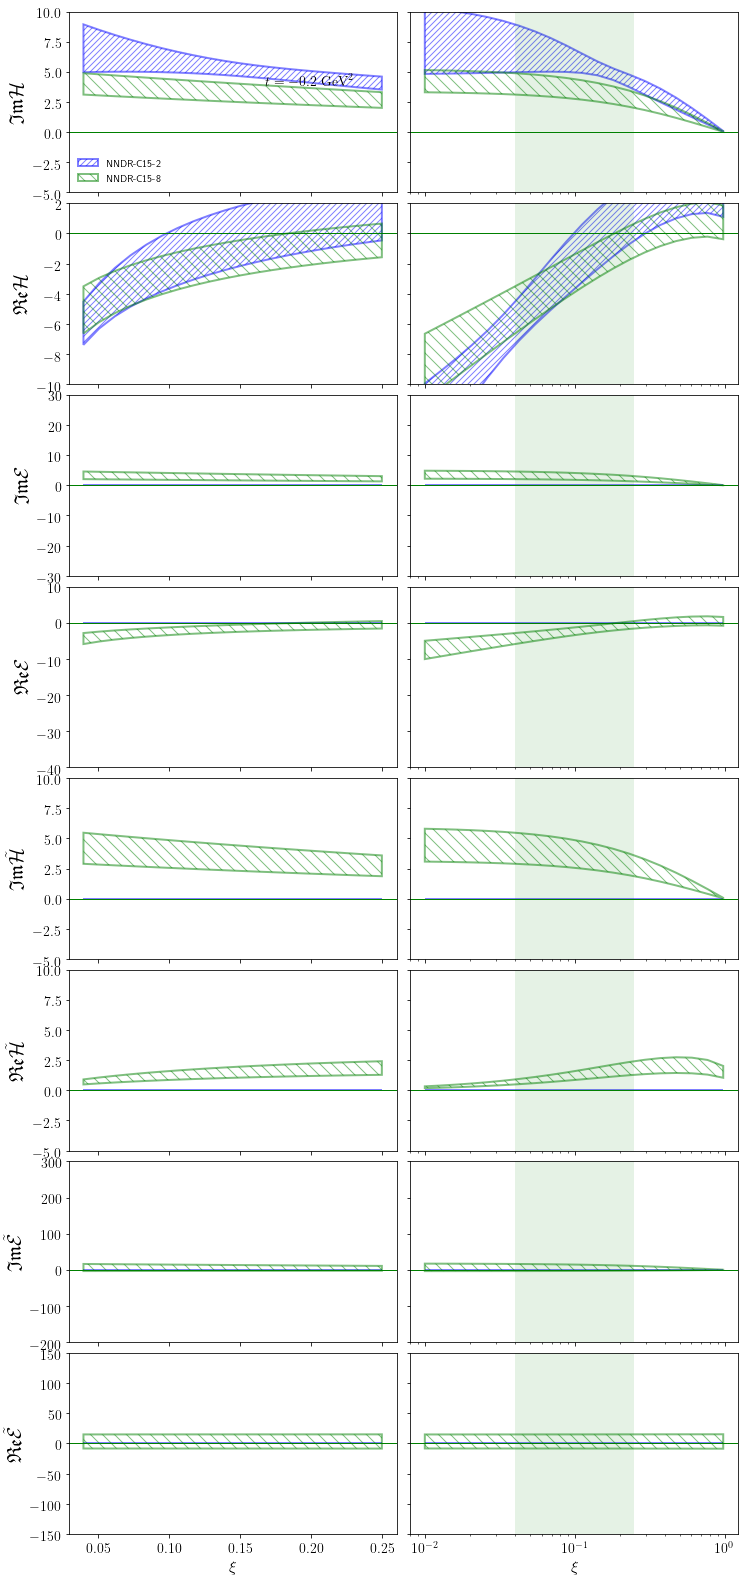

In [36]:
fig = plots.CFF(bands=[dbndr['NNDR-C15-2'], dbndr['NNDR-C15-8']], cffs=['ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt'])

In [37]:
fig.savefig('figs/NNDR-8.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

One notices significant shift in $\Im m \mathcal{H}$, in contrast to very narrow gray bands in Burkert et al.

Finally, let's see resulting values of D-term, for these same two models. Here "D-term" is $D(t)$ from most of the recent Maxim's papers, which is equal to $\frac{4}{5} d_{1}(t)$

In [38]:
ptts = []
for tm in [0.1, 0.2, 0.3, 0.4]:
    ptb = copy.deepcopy(data[102][5])  # take some random point and set/change -t
    ptb.t = -tm
    ptb.tm = tm
    th15.prepare(ptb)
    ptts.append(ptb)

In [39]:
D = []
for th in [dbndr['NNDR-C15-2'], dbndr['NNDR-C15-8']]:
    print("\n---- [{} - {}] ----".format(th.name, th.description))
    A = []
    for pt in ptts[::-1]:
        Ds = []
        for k in range(len(th.m.nets)):
            th.m.parameters['nnet'] = k
            # NOTE: subtraction in code is equal to -\Delta(t) !
            Ds.append(-th.m.subtraction(pt)*18./25.)
        Ds = np.array(Ds)
        print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), Ds.std()))
        A.append((pt.tm, Ds.mean(), Ds.std()))
    th.m.parameters['nnet'] = 'ALL'
    D.append(A)


---- [NNDR-C15-2 - 10 NNs C15 13.8/36 p=1] ----
0.214, -0.4: 1.58561897172 +- 1.45896604907
0.214, -0.3: 1.59642416907 +- 1.43645661973
0.214, -0.2: 1.60781847152 +- 1.41584610136
0.214, -0.1: 1.61909988418 +- 1.39692991036

---- [NNDR-C15-8 - 10 NNs C15 18.1/36 p=0.994] ----
0.214, -0.4: 0.0990883874031 +- 0.813695537362
0.214, -0.3: 0.092405625256 +- 0.80189448461
0.214, -0.2: 0.0865863638631 +- 0.793530686348
0.214, -0.1: 0.0815217317982 +- 0.789401094519


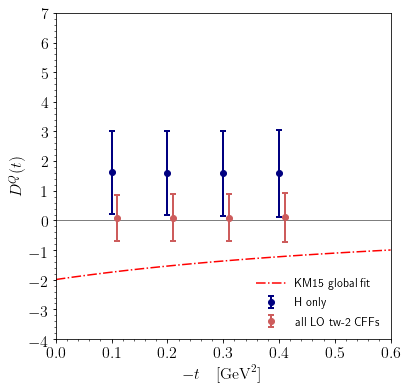

In [40]:
NPTS = 20
ts = np.linspace(0, 0.6, NPTS)
KMS = np.array([-(18./25.)*2.768/(1.+tm/1.204**2)**2 for tm in ts])
CDS = np.array(D[0])
CADS = np.array(D[1])
fig, ax = plt.subplots(1, 1,  figsize=[6,6])
ax.axhline(y=0, linewidth=0.5, color='k')  # y=0 thin line
ax.plot(ts, KMS, 'r-.', label='KM15 global fit')
ax.errorbar(CDS[:,0], CDS[:,1], CDS[:,2], linestyle='None', color='navy',
            elinewidth=2, capsize=3, capthick=2, marker='o', label='H only')
ax.errorbar(CADS[:,0,]+0.01, CADS[:,1], CADS[:,2], linestyle='None', elinewidth=2,
            capsize=3, capthick=2, marker='o', color='indianred', label='all LO tw-2 CFFs')

ax.set_xlim(0.0, 0.6)
ax.set_ylim(-4, 7)
ax.legend(loc=4, handlelength=2.5,
            prop=matplotlib.font_manager.FontProperties(size="large")
        ).draw_frame(0)
ax.set_xlabel(r'$-t \quad [{\rm GeV}^2]$', fontsize=16)
ax.set_ylabel(r'$D^{Q}(t)$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)) 
ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.02)) 
ax.yaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(1.)) 
ax.yaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.2)) 

One notices that CLAS 2015 data actually prefer slightly positive D-term (but are consistent with negative one, which is expected from stability criterion). It is interesting to compare this to preliminary JLab **timelike** DVCS measurement, arXiv:[1302.3088](http://arxiv.org/abs/arXiv:1302.3088), which also seems to prefer positive D-term. As demonstrated by KM fits, after including data from other experiments, negative D-term is preferred.

# Pressure distribution

## Code for  pressure in terms of D-term

<b>Note:</b> In formulas here "D-term" is $D(t)$ from most of the recent Maxim's papers, which is equal to $\frac{4}{5} d_{1}(t)$.

In [41]:
def Dterm(t, D0=-1.6, M=0.7, p=3):
    """D-term parametrization"""
    return D0/(1-t/M**2)**p

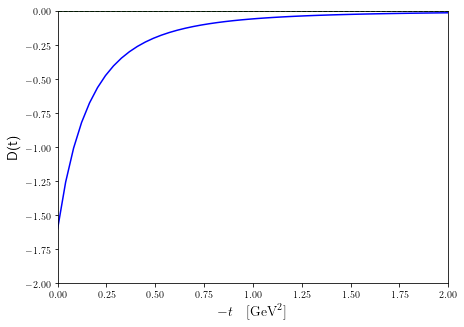

In [42]:
# Plotting this D-term
fig, ax = plt.subplots(1, 1, figsize=[7,5])
tms = np.linspace(0,2)
ax.plot(tms, Dterm(-tms), 'b-')
ax.set_ylabel(r'D(t)', fontsize=14)
ax.set_xlabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.set_ylim(-2,0)
fig.savefig('figs/dterm.pdf')

Note that D-term is dimensionless, while dimension of pressure in natural units is GeV$^4$, so $r^2 p(r)$ is GeV$^2$. We will divide by 0.197 to get result in GeV/fm instead.

In [43]:
def pressureNnaive(r, Dterm, **args):
    """Pressure distribution r^2*p(r) in GeV/fm for given Dterm(t) function"""
    GeVfm = 0.197
    Mp = 0.938
    rGeV = r/GeVfm
    intg = quad(lambda t: np.sin(np.sqrt(-t)*rGeV)*t*Dterm(t, **args), -np.inf, 0, epsabs=0)
    return intg[0]/(24*np.pi**2*Mp*rGeV) * rGeV**2 / GeVfm

In [44]:
def pressureN(r, Dterm, **args):
    """Pressure distribution r^2*p(r) in GeV/fm for given Dterm(t) function"""
    GeVfm = 0.197
    Mp = 0.938
    rGeV = r/GeVfm
    # variable change x=-t^2, so QUADPACK Fourier integral method can be used
    intg = quad(lambda x: 2*x*(-x**2)*Dterm(-x**2, **args), 0, np.inf, weight='sin', wvar=rGeV)
    return intg[0]/(24*np.pi**2*Mp*rGeV) * rGeV**2 / GeVfm

Integral involved here can be somewhat numerically demanding due to oscillatory behaviour of integrand and slow decay for large $-t$, but it can be performed analytically for cases $p=2,3$, which is convenient for doing checks on numerical routines below:

In [45]:
def pressureA(r, D0=-1.6, M=0.7, p=3):
    """Pressure distribution r^2*p(r) in GeV/fm for specific Dterm(t) function
    
     D(t) = D0/(1-t/M^2)^p  with p=2 or 3
    
    """
    GeVfm = 0.197
    Mp = 0.938
    assert p in [2,3]
    rGeV = r/GeVfm
    res = D0 * M**(2+p) * rGeV**(p-3) * np.exp(-M*rGeV) * (M*rGeV - p)
    return rGeV**2 * res / (2**(2*p) * 3 * np.pi * Mp) / GeVfm

In [46]:
D0val, Mval, pval = -1.6, 0.7, 3
pressureA(0.3, D0=D0val, M=Mval, p=pval), pressureNnaive(0.3, Dterm, D0=D0val, M=Mval, p=pval), pressureN(0.3, Dterm, D0=D0val, M=Mval, p=pval)

/usr/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


(0.0037265359461670666, 0.003726545962032528, 0.00372653594438695)

For fastly decaying integrand, $\propto (1-t/M^2)^3$, all methods agree.

In [47]:
D0val, Mval, pval = -1.6, 1.3, 2
pressureA(0.3, D0=D0val, M=Mval, p=pval), pressureNnaive(0.3, Dterm, D0=D0val, M=Mval, p=pval), pressureN(0.3, Dterm, D0=D0val, M=Mval, p=pval)

/usr/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


(0.0007003436725664407, -0.027815739561061346, 0.0007003436730263116)

For slowly converging integrand (smaller power of D-term denominator) naive integration fails. So we use better numerical method from now on:

In [48]:
pressure = pressureN

## Pressure distribution - mean values

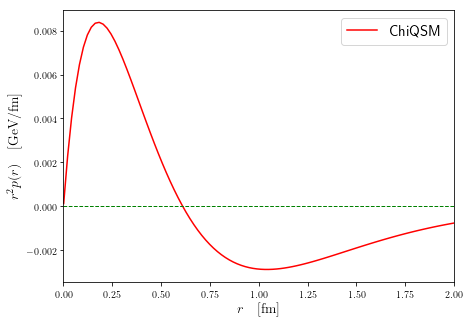

In [49]:
# Plotting the distribution for ChiQSM parameters from hep-ph/0702030
# d_1(0) = -2.35, M = 0.646,  so D(0) = 1.88
fig, ax = plt.subplots(1, 1, figsize=[7,5])
rs = np.linspace(0.001,2,100)
ps = []
for r in rs:
    ps.append(pressure(r, Dterm, D0=-1.88, M=0.646, p=2))
ax.plot(rs, ps, 'r-', label='ChiQSM')
ax.set_ylabel(r'$r^2 p(r) \quad[{\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.legend(loc="upper right", fontsize=15)
fig.savefig('figs/pressure.pdf')

This is in perfect agreement with Fig. 4 of hep-ph/0702030. 

Let's now plot the same for Parameters from Burkert et al., Nature. Here, there is some confusion about what is their $d_{1}$. Numbers from Burkert's presentation on Grips QCD workshop seem to imply that $D^{Q}(0) = \frac{18}{25} d_{1}^{Q}(0)$, which would mean that $d_{1}$ in Nature paper is actually equal to subtraction constant $\Delta(t)$. OTOH, Maxim and Peter naturally plot $d_{1}$ assuming it is equal to usual gravitational form factor, as defined above. There also seems to be a possibility, see below, that charge prefactor $\sum_q Q_{q}^2 = 5/9$ is missing somewhere.

Let's plot pressure distribution under these two different assumptions:

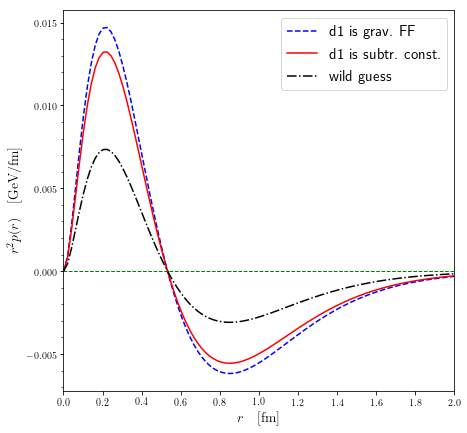

In [50]:
Mval = np.sqrt(1.06)
D0val = -2.04 * (4./5.) # d_1 is grav. form. fact.
D0valA = -2.04 * (18./25.)  # d_1 is subtr. const
D0valB = -2.04 * (18./25.)*(5./9.)  # wild guess
fig, ax = plt.subplots(1, 1, figsize=[7,7])
rs = np.linspace(0.001,2,100)
ps = []
psA = []
psB = []
for r in rs:
    ps.append(pressure(r, Dterm, D0=D0val, M=Mval, p=2.76))   
    psA.append(pressure(r, Dterm, D0=D0valA, M=Mval, p=2.76))
    psB.append(pressure(r, Dterm, D0=D0valB, M=Mval, p=2.76))
ax.plot(rs, ps, 'b--', label='d1 is grav. FF')
ax.plot(rs, psA, 'r-', label='d1 is subtr. const.')
ax.plot(rs, psB, 'k-.', label='wild guess')
ax.set_ylabel(r'$r^2 p(r) \quad[{\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.legend(loc="upper right", fontsize=15)
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.001))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.2))
fig.savefig('figs/pressure.pdf')

I assume there is a typo in the Nature (where y-axis is labeled with $10^{-2}$ factor, but it should be $10^{-3}$), and Burkert's presentation on Grips QCD conference seems to confirm this typo. However, there is still roughly a factor of 2 discrepancy with Nature/Grips plots: height of first maximum there is about 0.0075, while I get about 0.015 here! This should be understood at some point. I can get almost the same curve by removing the charge factor 5/9 ("wild guess" above) but such calculation would be difficult to understand.

## Pressure distribution - uncertainties

Let's add their stat and sys errors in quadrature and do very simple MC error propagation. This should be improved (MC error propagation to the numerical integral above is tricky: Gaussian is transformed into very slowly decaying asymmetric distribution).

In [51]:
d0, M, p = -2.04 * (18./25.)*(5./9.), np.sqrt(1.06), 2.76
d0err = np.sqrt(0.14**2 + 0.33**2) * (18./25.)*(5./9.)
M2err = np.sqrt(0.1**2 + 0.15**2)
Merr = M2err/2/M
perr = np.sqrt(0.25**2 + 0.5**2)

In [52]:
# Sampling from Gaussian/normal distribution using scipy's stats routines
ss = 50 #  sample size
d0MC = norm.rvs(d0, d0err, size=ss)
MMC = norm.rvs(M, Merr, size=ss)
pMC = norm.rvs(p, perr, size=ss)

In [53]:
rs = np.linspace(0.01,2,100)
psmean = []
psup = []
psdown = []
for r in rs:
    pressMC = []
    for k in range(ss):
        pressMC.append(pressure(r, Dterm, D0=d0MC[k], M=MMC[k], p=pMC[k]))
    mean, std = 1000*np.mean(pressMC), 1000*np.std(pressMC)
    psmean.append(mean)
    psup.append(mean+std)
    psdown.append(mean-std)

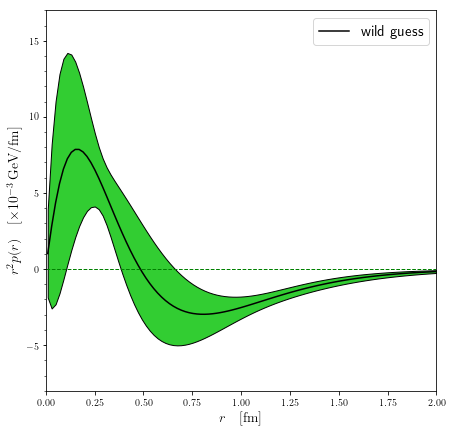

In [54]:
# I need to use "wild guess" option above to get agreement Fig. from Nature
fig, ax = plt.subplots(1, 1, figsize=[7,7])
ax.plot(rs, psmean, 'k-', label='wild guess')
ax.fill_between(rs, psup, psdown,
                    facecolor='limegreen',
                    edgecolor='black', linewidth=1, zorder=0)
ax.set_ylabel(r'$r^2 p(r) \quad[\times 10^{-3}\; {\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.set_ylim(-8, 17)
ax.legend(loc="upper right", fontsize=15)
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
fig.savefig('figs/pressure_nat.pdf')

So, error propagation seems to be O.K.

We now take **uncertainties as given by Neural nets** unbiased approach (we take the $\mathcal{H}$-only model `NNDR-C15-2` as Burkert at al.), while keeping their functional form and mean values for D-term.

In [55]:
d0, M, p = -2.04 * (18./25.)*(5./9.), np.sqrt(1.06), 2.76
d0err = 1.4 * (18./25.)  # as seen above, this is essentially t-independent
M2err = np.sqrt(0.1**2 + 0.15**2)
Merr = M2err/2/M
perr = np.sqrt(0.25**2 + 0.5**2)

In [56]:
d0MC = norm.rvs(d0, d0err, size=ss)
MMC = norm.rvs(M, Merr, size=ss)
pMC = norm.rvs(p, perr, size=ss)

In [57]:
rs = np.linspace(0.01,2,100)
psmean = []
psup = []
psdown = []
for r in rs:
    pressMC = []
    for k in range(ss):
        pressMC.append(pressure(r, Dterm, D0=d0MC[k], M=MMC[k], p=pMC[k]))
    mean, std = 1000*np.mean(pressMC), 1000*np.std(pressMC)
    psmean.append(mean)
    psup.append(mean+std)
    psdown.append(mean-std)

/usr/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: Bad integrand behavior occurs within one or more of the cycles.
  Location and type of the difficulty involved can be determined from 
  the vector info['ierlist'] obtained with full_output=1.
  warnings.warn(msg, IntegrationWarning)


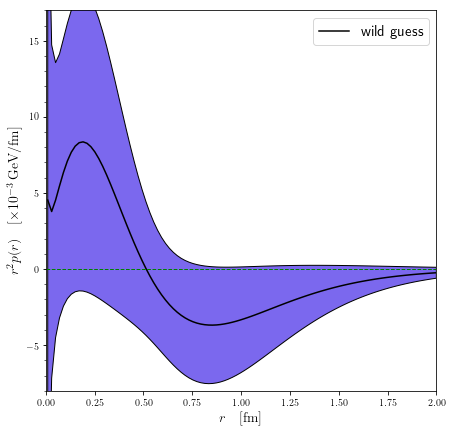

In [58]:
fig, ax = plt.subplots(1, 1, figsize=[7,7])
ax.plot(rs, psmean, 'k-', label='wild guess')
ax.fill_between(rs, psup, psdown,
                    facecolor='mediumslateblue',
                    edgecolor='black', linewidth=1, zorder=0)
ax.set_ylabel(r'$r^2 p(r) \quad[\times 10^{-3}\; {\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.set_ylim(-8, 17)
ax.legend(loc="upper right", fontsize=15)
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
fig.savefig('figs/pressure_NNet.pdf')

So, even if we would agree with mean value of D-term as extracted by Burkert et al., uncertainties are much larger, making pressure consistent with zero everywhere. If we also take into account mean value of D-term as extracted by this neural net fit (which is positive!), we are even further at odds from Burkert et al. result. So, with realistic uncertainty coming from unbiased procedure, we still **cannot detect quark pressure** from present CLAS data **alone**.

# Successful KM  fit  to CLAS 2015 with D(t)=0

Alternative way to convince onself that CLAS 2015 data alone doesn't conclusively imply non-zero pressure is via fitting this data using parametrization with zero subtraction constant. It turns out that this is possible using old `KM09a` parametrization from arXiv:[0904.0458](http://arxiv.org/abs/arXiv:0904.0458), using same values for parameters as there, but setting subtraction constant to zero. This is easy to check for everybody since `KM09a` parametrization is simple analytic function that also for sea partons uses the same "KM" parametrization of $\Im m \mathcal{H}$ (and not conformal moment space sea modelling like e.g. `KM15`).

In [59]:
th09azero = copy.deepcopy(db['KM09a'])  # Loading from model database
th09azero.name = 'KM09a(C=0)'

In [60]:
th09azero.m.parameters.update({'C':0})  # Setting D-term to zero

There is also a pion pole contribution to $\Re e\tilde{\mathcal{E}}$ in original `KM09a`., It is actually numerically insignificant for present analysis. For consistency, we now also set it to zero by hand (so that only $\mathcal{H}$ contribution remains), but one gets essentially the same chi-square and plots with and without it.

In [61]:
def zero(pt):
    return 0

In [62]:
th09azero.m.ReEt = zero

In [63]:
# The result of actual MINUIT fit to CLAS 2015 xs data 
#   (but not needed since it's very close)
# th09zero.m.parameters.update({'C':0, 'bS':3.249, 'rv':1.131, 'bv':0.463})

That fit is good can be seen from $\chi^2$ in $\phi$-space:

In [64]:
th09azero.print_chisq(utils.select(data[99]+data[100], criteria=['err > 0']))

P(chi-square, d.o.f) = P(1751.39, 2023) = 1.0000


and in space of harmonics:

In [65]:
th09azero.print_chisq(data[101]+data[102])

P(chi-square, d.o.f) = P(57.68, 139) = 1.0000


and from the plots in $\phi$-space:

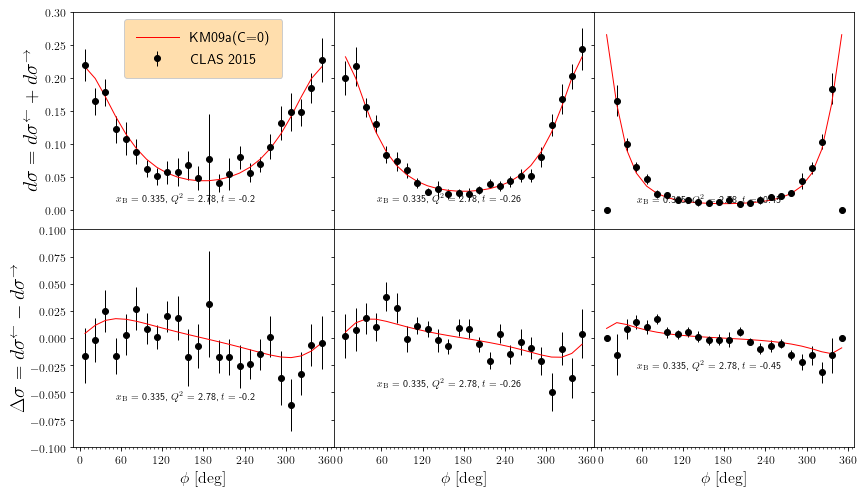

In [66]:
fig = plots.CLAS15phi(lines=[th09azero])

In [67]:
fig.savefig('figs/th09azero.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

and in the space of harmonics:

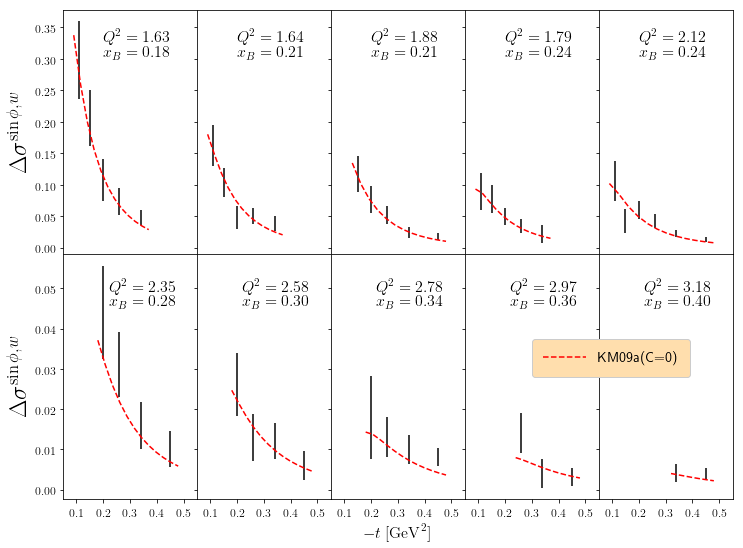

In [68]:
figw = plots.CLAS15xs(lines=[th09azero])

In [69]:
figw.savefig('figs/th09azerow.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

# (Appendix) Local fit to CLAS 2015 data

## Reminder how local fits are done (HERMES data)

Our main point are uncertainties, as provided by neural network fits, but since we also find some discrepancies in mean values, let's do some fast local least-squares fits as well. As a warm-up, we reproduce our own local fit to HERMES data so that we remind ourselves of the local fit procedures.

In [70]:
# Updated 4-t-bin data by Morgan
bins = zip(L4_ALUI, L4_AC_1, L4_AUL, L4_ALL_1,
           L4_AUTI_1, L4_AUTI_m1, L4_ALTI_1, L4_ALTI_m1)

In [71]:
totchi = 0
ndof = 0
sys.stdout.write('-- Bin: ')
CFFs = ['pImH', 'pReH', 'pImHt']
CFFvals = []
CFFerrs = []
for nbin in range(len(bins)):
    # Model creation
    m = Model.ModelLocal()
    m.parameters['pImH'] = 10.
    th = Approach.BM10(m)
    th.name = 'local-bin-%2s' % (nbin+1,)
    th.model.fix_parameters('ALL')
    th.model.release_parameters(*CFFs)
    # Fit to data in given bin
    sys.stdout.write('%2s .. ' % (nbin+1,))
    f = Fitter.FitterMinuit(bins[nbin], th)
    #f.printMode = 2
    f.fit()
    totchi += th.chisq(f.fitpoints)[0]
    ndof += len(f.fitpoints)-len(CFFs)
    vals= []
    errs = []
    for p in CFFs:
            vals.append(th.m.parameters[p])
            errs.append(np.sqrt(th.m.covariance[p,p]))
    CFFvals.append(vals)
    CFFerrs.append(errs)
    
CFFvals = np.array(CFFvals)
CFFerrs = np.array(CFFerrs)

print("\n chisq/ndof = {:.1f}/{}".format(totchi,ndof))

-- Bin:  1 ..  2 ..  3 ..  4 ..  5 ..  6 ..  7 ..  8 ..  9 .. 10 .. 11 .. 12 .. 
 chisq/ndof = 44.3/60


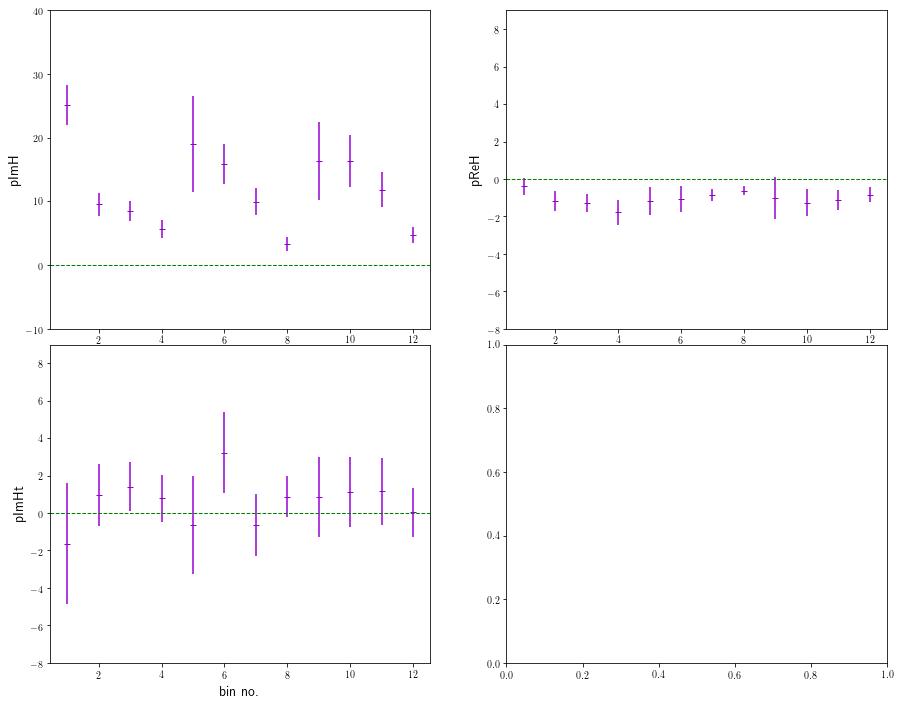

In [72]:
fig, axs = plt.subplots(2, 2, figsize=[15,12])
axs = axs.flatten()
for p in range(3):
    ax = axs[p]
    ax.errorbar(np.arange(1,13), CFFvals[:,p], CFFerrs[:,p], linestyle='None', 
                 marker='_', color='darkviolet', capsize=0)
    ax.set_ylabel(r'{}'.format(CFFs[p]), fontsize=14)
    ax.set_xlabel(r'bin no.', fontsize=14)
    ax.axhline(linestyle='--', color='g', lw=1)
axs[0].set_ylim(-10,40)
axs[1].set_ylim(-8,9)
axs[2].set_ylim(-8,9)
fig.subplots_adjust(hspace=0.05)
fig.savefig('/home/kkumer/HA17bin-BSS.pdf')

This is in excellent agreement with the published plot (Fig. 6 from arXiv:[1301.1230](http://arxiv.org/abs/arXiv:1301.1230)):

![KMM12](img/hermes_local.png "Local fits to HERMES DVCS data")

## Local fit of ImH and ReH to CLAS data

In [73]:
tNN = dbndr['NNDR-C15-2']  # NNet fit result, just for plotting below for comparison with local fits
tNN.m.output_layer

['ImH', 'ReH']

In [74]:
binD = {}
binS = {}
binDS = {}

In [75]:
def tmin(xB, Q2):
    """BMK Eq. (31)"""

    eps2 = (4. * xB**2 * Mp2) / Q2
    return (-Q2 * ( 2. * (1.-xB)*(1. - np.sqrt(1.+eps2)) + eps2 ) / (
            4. * xB * (1.-xB) + eps2 ))

In [76]:
def makefit(tbin, nxis): 
    """ Perform simultaneous fit of both ImH and ReH."""
    for xbin in range(nxis):
        binD[(tbin,xbin)] = BSD.loc[(tmlims[tbin] < BSD.tm) & 
                                    (BSD.tm < tmlims[tbin+1]) & 
                             (xilims[xbin] < BSD.xi) & (BSD.xi < xilims[xbin+1])]
        binS[(tbin,xbin)] = BSS.loc[(tmlims[tbin] < BSS.tm) & 
                                    (BSS.tm < tmlims[tbin+1]) & 
                             (xilims[xbin] < BSS.xi) & (BSS.xi < xilims[xbin+1])]
        binDS[(tbin,xbin)] = pd.concat([binD[(tbin,xbin)], 
                                        binS[(tbin,xbin)]], ignore_index=True)
    totchi = 0
    ndof = 0
    sys.stdout.write('-- Bin: ')
    CFFs = ['pImH', 'pReH']
    CFFvals = []
    CFFerrs = []
    xis = []
    pts = []
    for xbin in range(nxis):
        # Model creation
        m = Model.ModelLocal()
        m.parameters['pImH'] = 10.
        th = Approach.BM10tw2(m)
        th.name = 'local-bin-%2s' % (xbin,)
        th.model.fix_parameters('ALL')
        th.model.release_parameters(*CFFs)
        # Fit to data in given bin
        sys.stdout.write('%2s .. ' % (xbin,))
        f = Fitter.FitterMinuit(binDS[(tbin,xbin)].pt.values, th)
        xis.append(binDS[(tbin,xbin)].xi.mean())
        pts.append(binD[(tbin,xbin)].pt.values[0])
        #f.printMode = 2
        f.fit()
        totchi += th.chisq(f.fitpoints)[0]
        ndof += len(f.fitpoints)-len(CFFs)
        vals= []
        errs = []
        for p in CFFs:
                vals.append(th.m.parameters[p])
                errs.append(np.sqrt(th.m.covariance[p,p]))
        CFFvals.append(vals)
        CFFerrs.append(errs)

    CFFvals = np.array(CFFvals)
    CFFerrs = np.array(CFFerrs)

    print("\n chisq/ndof = {:.1f}/{}".format(totchi,ndof))
    return xis, pts, CFFvals, CFFerrs

Stepwise fit (with ReH fitted to BSS after ImH is fixed by fit to BSD) code that follows, results in 10% smaller ReH uncertainty w.r.t. simultaneous fit using code above. This is to be expected according to bias-variance trade-off (step-wise model is more rigid i.e. biased), but effect is not too important. We will not use this stepwise fit.

In [77]:
def makefitstep(tbin, nxis):
    """ Perform step-wise fit, first ImH, then ReH ... not significant"""
    for xbin in range(nxis):
        binD[(tbin,xbin)] = BSD.loc[(tmlims[tbin] < BSD.tm) & 
                                    (BSD.tm < tmlims[tbin+1]) & 
                             (xilims[xbin] < BSD.xi) & (BSD.xi < xilims[xbin+1])]
        binS[(tbin,xbin)] = BSS.loc[(tmlims[tbin] < BSS.tm) & 
                                    (BSS.tm < tmlims[tbin+1]) & 
                             (xilims[xbin] < BSS.xi) & (BSS.xi < xilims[xbin+1])]
        binDS[(tbin,xbin)] = pd.concat([binD[(tbin,xbin)], 
                                        binS[(tbin,xbin)]], ignore_index=True)
    totchi = 0
    ndof = 0
    sys.stdout.write('-- Bin: ')
    CFFs = ['pImH', 'pReH']
    CFFvals = []
    CFFerrs = []
    xis = []
    pts = []
    for xbin in range(nxis):
        # Model creation
        m = Model.ModelLocal()
        m.parameters['pImH'] = 10.
        th = Approach.BM10tw2(m)
        th.name = 'local-bin-%2s' % (xbin,)
        th.model.fix_parameters('ALL')
        sys.stdout.write('%2s .. ' % (xbin,))
        xis.append(binDS[(tbin,xbin)].xi.mean())
        pts.append(binD[(tbin,xbin)].pt.values[0])
        # Fit to BSD data in given bin
        th.model.release_parameters('pImH')
        f = Fitter.FitterMinuit(binD[(tbin,xbin)].pt.values, th)
        #f.printMode = 2   
        f.fit()
        totchi += th.chisq(f.fitpoints)[0]
        ndof += len(f.fitpoints)-1
        valImH = th.m.parameters['pImH']
        errImH = np.sqrt(th.m.covariance['pImH','pImH'])
        # Now fit to BSS data
        th.model.fix_parameters('pImH')
        th.model.release_parameters('pReH')
        f = Fitter.FitterMinuit(binS[(tbin,xbin)].pt.values, th)
        f.fit()
        totchi += th.chisq(f.fitpoints)[0]
        ndof += len(f.fitpoints)-1
        th.model.release_parameters('pImH')
        valReH = th.m.parameters['pReH']
        errReH = np.sqrt(th.m.covariance['pReH','pReH'])
        vals= [valImH, valReH]
        errs = [errImH, errReH]
        CFFvals.append(vals)
        CFFerrs.append(errs)

    CFFvals = np.array(CFFvals)
    CFFerrs = np.array(CFFerrs)

    print("\n chisq/ndof = {:.1f}/{}".format(totchi,ndof))
    return xis, pts, CFFvals, CFFerrs

In [78]:
def makefig():
    """Plot the results of the local fits together with NNet and KM fits"""
    xirange = np.linspace(0.05, 0.3, 20)
    CFFs = ['ImH', 'ReH']
    ex_pt = copy.deepcopy(pts[0])
    fig, axs = plt.subplots(1, 2, figsize=[12,6])
    for p in range(2):
        axs[p].errorbar(xis, CFFvals[:,p], CFFerrs[:,p], linestyle='None', marker='s', 
                       label='local fit')
        ys = []
        ys2 = []
        ysNN = []
        ysNNerr = []
        for xi in xirange:
            pt = copy.deepcopy(ex_pt)
            pt.xB = 2*xi/(1+xi)
            del pt.W
            del pt.xi
            del pt.tm
            utils.fill_kinematics(pt)
            th15.m.g.newcall = 1
            y = getattr(th15.m, CFFs[p])(pt)
            th12.m.g.newcall = 1
            y2 = getattr(th12.m, CFFs[p])(pt)
            try:
                yall = getattr(tNN.m, CFFs[p])(pt)
                ysNN.append(yall.mean())
                ysNNerr.append(yall.std())
            except:
                print('some NN failure')
                pass    
            ys.append(y)
            ys2.append(y2)
        ysNN = np.array(ysNN)
        ysNNerr = np.array(ysNNerr)
        axs[p].fill_between(xirange, ysNN-ysNNerr, ysNN+ysNNerr, alpha=0.2,
                    label=tNN.name, color='green')#, zorder=0)
        axs[p].plot(xirange, ys, 'r-', label='KM15')
        axs[p].plot(xirange, ys2, 'k--', label='KMM12')
        axs[p].set_xlabel(r'$\xi$', fontsize=14)
        axs[p].set_xlim(0.03, 0.31)
    #axs[0].set_ylabel(r'Im(H)', fontsize=14)
    axs[0].set_ylabel(r'$\mathfrak{Im}\,\mathcal{H}$', fontsize=18)
    axs[0].set_ylim(0., 10.)
    axs[1].legend(loc="lower right", fontsize=15)
    axs[1].set_ylabel(r'Re(H)', fontsize=14)
    axs[1].set_ylabel(r'$\mathfrak{Re}\,\mathcal{H}$', fontsize=18)      
    axs[1].axhline(y=0, linewidth=0.8, linestyle=':', color='k')  # y=0 thin line
    axs[1].set_ylim(-10., 4.)
    axs[0].text(0.05, 1, r'$t = {}\,{{\rm GeV}}^2$'.format(pts[0].t), fontsize=15,
                bbox=dict(facecolor='gold', alpha=0.3))
    return fig

-- Bin:  0 ..  1 ..  2 .. 
 chisq/ndof = 4.0/9


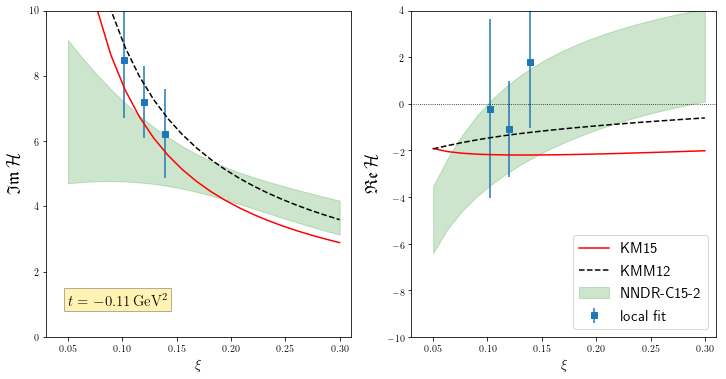

In [79]:
xis, pts, CFFvals, CFFerrs = makefit(0,3)
fig = makefig()

This is to be compared with Nature fig:

![fig2a](img/nat-fig2a.png "Nature Fig 2a -t = 0.11 GeV^2")

-- Bin:  0 ..  1 ..  2 .. 
 chisq/ndof = 5.6/9


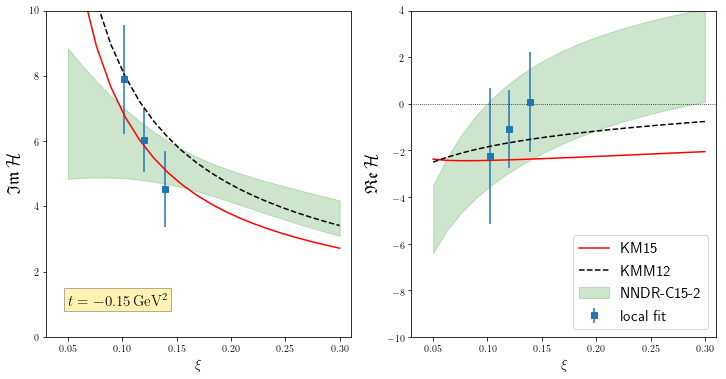

In [80]:
xis, pts, CFFvals, CFFerrs = makefit(1,3)
fig = makefig()

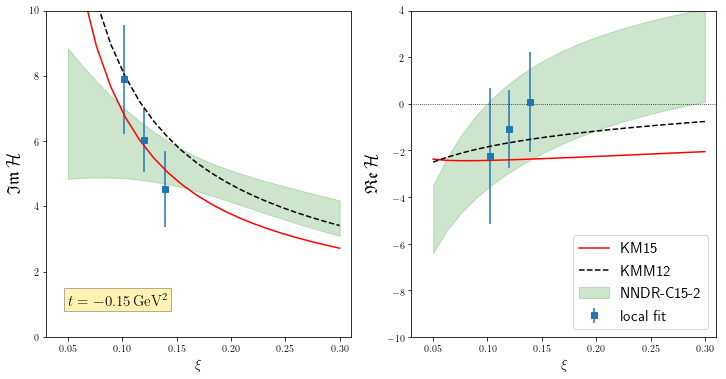

In [81]:
fig = makefig()

![fig1](img/nat-fig1.png "Nature Fig 2a -t = 0.15 GeV^2")

-- Bin:  0 ..  1 ..  2 ..  3 ..  4 ..  5 .. 
 chisq/ndof = 7.6/18


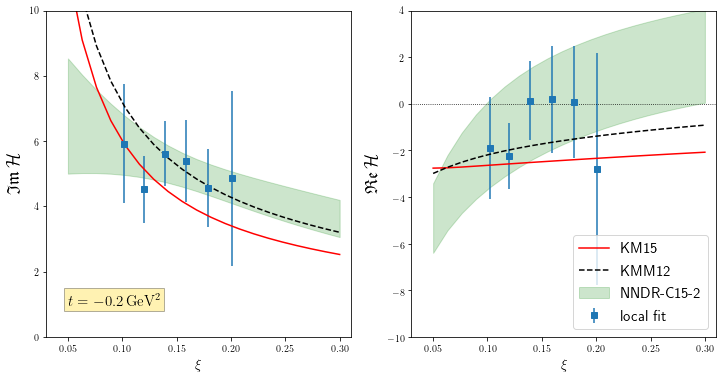

In [82]:
xis, pts, CFFvals, CFFerrs = makefit(2,6)
fig = makefig()

In [83]:
fig.savefig('/home/kkumer/nat_0.2.png')

![fig2b](img/nat-fig2b.png "Nature Fig 2b: -t = 0.20 GeV^2")

-- Bin:  0 ..  1 ..  2 ..  3 ..  4 ..  5 ..  6 .. 
 chisq/ndof = 6.7/16


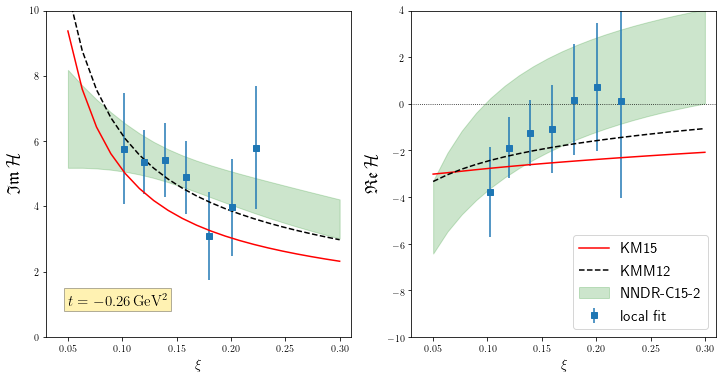

In [84]:
xis, pts, CFFvals, CFFerrs = makefit(3,7)
fig = makefig()

![fig3a](img/nat-fig3a.png "Nature Fig 3a -t = 0.26 GeV^2")

-- Bin:  0 ..  1 ..  2 ..  3 ..  4 ..  5 ..  6 ..  7 .. 
 chisq/ndof = 9.4/17


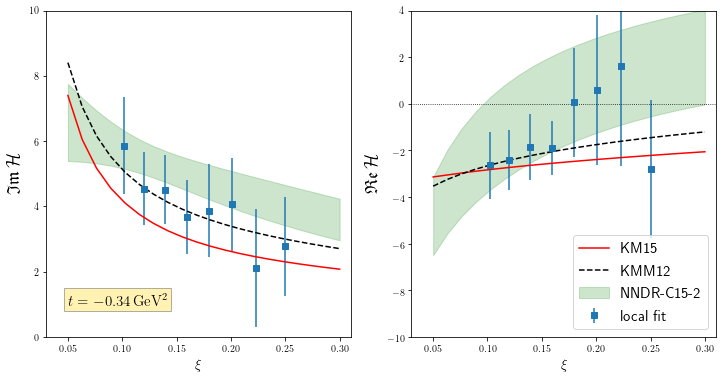

In [85]:
xis, pts, CFFvals, CFFerrs = makefit(4,8)
fig = makefig()

![fig3b](img/nat-fig3b.png "Nature Fig 3b: -t = 0.34 GeV^2")

Local fits presented here are consistent with neural net results from previous sections. They have smaller (less negative) ReH, and with significantly larger uncertainty than in Nature paper (and there is also upward shift!)

# (Appendix) Plot for inclusion in the comment

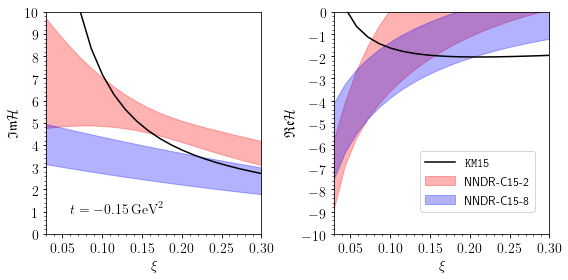

In [86]:
NPTS = 20
ex_pt = copy.deepcopy(data[25][4])
ex_pt.t = -0.15
ex_pt.Q2 = 4.

TH = db['KM15']
THNN = dbndr['NNDR-C15-2']
THNN2 = dbndr['NNDR-C15-8']

plt.close('all')
RASTER = False
rorder = -3000
if RASTER:
    rorder = 1

fig, axs = plt.subplots(1, 2, sharex=True, figsize=[8,4])
axs = axs.reshape(2)
cffs = ['ImH', 'ReH']
ylims = {
        'ImH': (0, 10), 'ReH': (-10, 0),
         'ImE': (-40, 35), 'ReE': (-40, 10),
         'ImEt': (-200, 300), 'ReEt': (-150, 150),
         'ImHt': (-6, 10), 'ReHt': (-12, 12)}
for cff, (pn, ax) in zip(cffs, enumerate(axs)):
    ax.set_rasterization_zorder(rorder)
    xis = np.linspace(0.03, 0.3, NPTS)
    ys = []
    ysNN = []
    ysNNerr = []
    ysNN2 = []
    ysNNerr2 = []
    for xi in xis:
        pt = copy.deepcopy(ex_pt)
        pt.xB = 2*xi/(1+xi)
        del pt.W
        del pt.xi
        del pt.tm
        utils.fill_kinematics(pt)
        
        TH.m.g.newcall = 1
        y = getattr(TH.m, cff)(pt)
        ys.append(y)
        
        try:
            yall = getattr(THNN.m, cff)(pt)
            ysNN.append(yall.mean())
            ysNNerr.append(yall.std())
        except:
            pass
        
        try:
            yall = getattr(THNN2.m, cff)(pt)
            ysNN2.append(yall.mean())
            ysNNerr2.append(yall.std())
        except:
            pass  
        
    ysNN = np.array(ysNN)
    ysNNerr = np.array(ysNNerr)
    ysNN2 = np.array(ysNN2)
    ysNNerr2 = np.array(ysNNerr2)

    ax.plot(xis, ys, 'k-', label=r'\texttt{%s}' % TH.name)

    ax.fill_between(xis, ysNN-ysNNerr, ysNN+ysNNerr, alpha=0.3,
                    label=r'{}'.format(THNN.name), color='red', zorder=0)
    ax.fill_between(xis, ysNN2-ysNNerr2, ysNN2+ysNNerr2, alpha=0.3,
                    label=r'{}'.format(THNN2.name), color='blue', zorder=0)

    ax.set_xlim(0.03, 0.3)
    ax.xaxis.set_major_locator(
            matplotlib.ticker.MultipleLocator(0.05)) 
    ax.xaxis.set_minor_locator(
            matplotlib.ticker.MultipleLocator(0.01)) 
    ax.yaxis.set_major_locator(
            matplotlib.ticker.MultipleLocator(1.)) 
    ax.yaxis.set_minor_locator(
            matplotlib.ticker.MultipleLocator(0.2)) 
    s1 = r'$t = {:.2f}\, {{\rm GeV}}^2$'.format(ex_pt.t)
    ax.set_ylabel(toTeX[cff], fontsize=14)
    apply(ax.set_ylim, ylims[cff])
    if pn >= 0:
        ax.set_xlabel(r'$\xi$', fontsize=14)
    if pn == 0:
        ax.text(0.06, 1, s1, fontsize=14)
        handles, labels = ax.get_legend_handles_labels()
        #axs[pn].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.01))
    if pn == 1:
        ax.legend(handles, labels, loc=(0.4, 0.1),
                  handlelength=2.5,
            prop=matplotlib.font_manager.FontProperties(size="large")
        ).draw_frame(1)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
plt.tight_layout(h_pad=0.) 
fig.savefig('figs/CFFs.pdf', format='pdf')

In [87]:
a = np.loadtxt('img/natfig_20a.dat')
alup = a[:24]
aldn = a[24:]

In [88]:
b = np.loadtxt('img/natfig_20b.dat')
lup = b[:29]
ldn = b[29:]

In [89]:
aJLBup = InterpolatedUnivariateSpline(alup[:,0], alup[:,1], k=1)
aJLBdn = InterpolatedUnivariateSpline(aldn[:,0], aldn[:,1], k=1)

In [90]:
JLBup = InterpolatedUnivariateSpline(lup[:,0], lup[:,1], k=1)
JLBdn = InterpolatedUnivariateSpline(ldn[:,0], ldn[:,1], k=1)

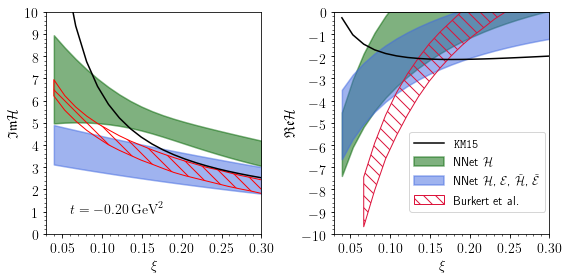

In [91]:
NPTS = 20
NN2 = True # Do we plot second NN?
ex_pt = copy.deepcopy(data[25][4])
ex_pt.t = -0.2
ex_pt.Q2 = 4.

TH = db['KM15']
THNN = dbndr['NNDR-C15-2']
THNN.name = r'NNet $\mathcal{H}$'
THNN2 = dbndr['NNDR-C15-8']
THNN2.name = r'NNet $\mathcal{H}$, $\mathcal{E}$, $\tilde{\mathcal{H}}$, $\tilde{\mathcal{E}}$'


plt.close('all')
RASTER = False
rorder = -3000
if RASTER:
    rorder = 1

fig, axs = plt.subplots(1, 2, sharex=True, figsize=[8,4])
axs = axs.reshape(2)
cffs = ['ImH', 'ReH']
ylims = {
        'ImH': (0, 10), 'ReH': (-10, 0),
         'ImE': (-40, 35), 'ReE': (-40, 10),
         'ImEt': (-200, 300), 'ReEt': (-150, 150),
         'ImHt': (-6, 10), 'ReHt': (-12, 12)}
for cff, (pn, ax) in zip(cffs, enumerate(axs)):
    ax.set_rasterization_zorder(rorder)
    xis = np.linspace(0.04, 0.30, NPTS)
    ys = []
    ysNN = []
    ysNNerr = []
    ysNN2 = []
    ysNN2err = []
    ysJLB = []
    ysJLBerr = []
    for xi in xis:
        pt = copy.deepcopy(ex_pt)
        pt.xB = 2*xi/(1+xi)
        del pt.W
        del pt.xi
        del pt.tm
        utils.fill_kinematics(pt)
        
        TH.m.g.newcall = 1
        y = getattr(TH.m, cff)(pt)
        ys.append(y)
        
        yall = getattr(THNN.m, cff)(pt)
        ysNN.append(yall.mean())
        ysNNerr.append(yall.std())
        
        if NN2:
            yall = getattr(THNN2.m, cff)(pt)
            ysNN2.append(yall.mean())
            ysNN2err.append(yall.std())
            
    ysNN = np.array(ysNN)
    ysNNerr = np.array(ysNNerr)
    
    if NN2:
        ysNN2 = np.array(ysNN2)
        ysNN2err = np.array(ysNN2err)

    ax.plot(xis, ys, 'k-', label=r'\texttt{%s}' % TH.name)

    ax.fill_between(xis, ysNN-ysNNerr, ysNN+ysNNerr,
                    label=r'{}'.format(THNN.name), 
                    color = 'darkgreen', alpha = 0.5,
                    # hatch = '\\\\', facecolor='none', edgecolor='blue', 
                    linewidth=1.5, zorder=0)
    if NN2:
        ax.fill_between(xis, ysNN2-ysNN2err, ysNN2+ysNN2err, #alpha=0.3,
                    label=r'{}'.format(THNN2.name),
                    color = 'royalblue', alpha = 0.5,
                    #hatch = '\\\\', facecolor='none', edgecolor='darkgreen', 
                    linewidth=1.5, zorder=0)
    
    if pn == 1:
        ax.fill_between(xis[2:-4], JLBdn(xis[2:-4]), JLBup(xis[2:-4]), #alpha=0.3,
                    label=r'Burkert et al.', #color='red',
                    hatch = '\\\\', facecolor='none',
                    edgecolor='crimson', linewidth=1.0,
                        zorder=0)
    else:
        ax.fill_between(xis, aJLBdn(xis), aJLBup(xis), #alpha=0.3,
                    label=r'Burkert et al.', #color='red', 
                    hatch = '\\\\', facecolor='none',
                    edgecolor='red', linewidth=1.0,
                        zorder=0) 
        
    ax.set_xlim(0.03, 0.3)
    ax.xaxis.set_major_locator(
            matplotlib.ticker.MultipleLocator(0.05)) 
    ax.xaxis.set_minor_locator(
            matplotlib.ticker.MultipleLocator(0.01)) 
    ax.yaxis.set_major_locator(
            matplotlib.ticker.MultipleLocator(1.)) 
    ax.yaxis.set_minor_locator(
            matplotlib.ticker.MultipleLocator(0.2)) 
    s1 = r'$t = {:.2f}\, {{\rm GeV}}^2$'.format(ex_pt.t)
    ax.set_ylabel(toTeX[cff], fontsize=14)
    apply(ax.set_ylim, ylims[cff])
    ax.axhline(y=0, linewidth=0.5, color='k')  # y=0 thin line
    if pn >= 0:
        ax.set_xlabel(r'$\xi$', fontsize=14)
    if pn == 0:
        ax.text(0.06, 1, s1, fontsize=14)
        #axs[pn].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.01))
    if pn == 1:
        #ax.set_ylabel(r'$\mathfrak{Im}\,\tilde{\cal H}$', fontsize=12)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc=(0.35, 0.1),
                  handlelength=2.5,
            prop=matplotlib.font_manager.FontProperties(size="large")
        ).draw_frame(1)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
plt.tight_layout(h_pad=0.) 
fig.savefig('figs/CFFs2.pdf', bbox_inches='tight', transparent=True, pad_inches=0)